# Qucik Start: Use Cases and Examples with Synthetic Data
---
This notebook provides an example of conducting an offline evaluation of the performance of two counterfactual policies using OPE estimators and synthetic logged bandit feedback.

Our example with synthetic data contains the follwoing four major steps:
- (1) Synthetic Data Generation
- (2) Offline Bandit Simulation
- (3) Off-Policy Evaluation
- (4) Evaluation of OPE Estimators

Please see [../synthetic/](https://github.com/st-tech/zr-obp/blob/master/examples/synthetic/) for a more sophisticated example of the evaluation of OPE.

In [1]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier as RandomForest
# import open bandit pipeline (obp)
from obp.dataset import (
    SyntheticBanditDataset,
    linear_reward_function,
    linear_behavior_policy
)
from obp.policy import BernoulliTS, LogisticEpsilonGreedy
from obp.simulator import run_bandit_simulation
from obp.ope import (
    OffPolicyEvaluation, 
    RegressionModel,
    InverseProbabilityWeighting,
    DirectMethod,
    DoublyRobust
)

## (1) Synthetic Data Generation
We prepare easy-to-use synthetic data generator: SyntheticBanditDataset class in dataset module.
It takes number of actions (n_actions), dimension of context vectors (dim_context, dim_action_context), reward function (reward_function), and behavior policy (behavior_policy_function) as inputs and generates synthetic bandit dataset with a given number of rounds.

In [2]:
# generate synthetic bandit dataset with 10 actions
# one can define their own `reward_function` and `behavior_policy_function` such as nonlinear ones. 
dataset = SyntheticBanditDataset(
    n_actions=20,
    dim_context=5,
    dim_action_context=5,
    reward_function=linear_reward_function,
    behavior_policy_function=linear_behavior_policy,
    random_state=12345
)
# obtain logged bandit feedback with 1 million rounds generated by linear contextual behavior polciy
n_rounds = 3000000
bandit_feedback = dataset.obtain_batch_bandit_feedback(n_rounds=n_rounds)

bandit_feedback # `bandit_feedback` is a dictionary storing synthetic logged bandit feedback

{'n_rounds': 3000000,
 'n_actions': 20,
 'context': array([[-1.56565729, -0.56254019, -0.03266414, -0.9290062 , -0.48257265],
        [-0.03626385,  1.09539006,  0.98092848, -0.58948769,  1.58170009],
        [-0.52873483,  0.45700187,  0.92996876, -1.56927061, -1.02248698],
        ...,
        [ 0.14093464,  0.51140764, -0.73929648,  0.55413315, -0.05296137],
        [ 0.35601098, -1.67909278, -0.84914553,  1.00320581, -0.12803874],
        [-0.87928967, -0.64552342, -0.87584156, -0.55704511, -0.417412  ]]),
 'action': array([14, 12,  3, ...,  3,  2, 12]),
 'position': array([0, 0, 0, ..., 0, 0, 0]),
 'reward': array([0, 1, 0, ..., 0, 0, 0]),
 'expected_reward': array([[0.23936236, 0.07412974, 0.2207826 , ..., 0.15291573, 0.0961332 ,
         0.1627115 ],
        [0.90478202, 0.87517842, 0.91925618, ..., 0.7943514 , 0.8340348 ,
         0.7517365 ],
        [0.39745571, 0.17478055, 0.3863221 , ..., 0.13397298, 0.25189057,
         0.34277153],
        ...,
        [0.37738818, 0.5737

## (2) Offline Bandit Simulation¶
After preparing a dataset, we now run offline bandit simulation on the logged bandit feedback.
We use Bernoulli Thompson Sampling impelemted in policy module as a first counterfacutal policy and Logistic Epsilon Greedy as a second counterfactual policy. <br>
run_bandit_simulation in simulation module takes a counterfactual policy and a training dataset as inputs and run the policy on the dataset.

In [3]:
# define the Bernoulli Thompson Sampling (Bernoulli TS) policy as a first counterfactual policy
counterfactual_policy_a = BernoulliTS(n_actions=dataset.n_actions, len_list=dataset.len_list)
# run Bernoulli TS on the synthetic bandit feedback
selected_actions_a = run_bandit_simulation(bandit_feedback=bandit_feedback, policy=counterfactual_policy_a)
# selected_actions is an array of shape (n_rounds, len_list)
# containing selected actions by counterfactual policy in an simulation
selected_actions_a

100%|██████████| 3000000/3000000 [01:45<00:00, 28309.11it/s]


array([[17],
       [13],
       [ 9],
       ...,
       [ 0],
       [13],
       [ 8]])

In [4]:
# define the Logistic Epsilon Greedy (Logistic Egreedy) policy as a second counterfactual policy
counterfactual_policy_b = LogisticEpsilonGreedy(
    n_actions=dataset.n_actions, 
    len_list=dataset.len_list,
    dim=dataset.dim_context,
    epsilon=0.05,
)
# run Logistic EGreedy on the synthetic bandit feedback
selected_actions_b = run_bandit_simulation(bandit_feedback=bandit_feedback, policy=counterfactual_policy_b)
# selected_actions is an array of shape (n_rounds, len_list)
# containing selected actions by counterfactual policy in an simulation
selected_actions_b

100%|██████████| 3000000/3000000 [06:44<00:00, 7420.38it/s]


array([[17],
       [15],
       [18],
       ...,
       [12],
       [ 1],
       [ 5]])

## (3) Off-Policy Evaluation (OPE)
Off-policy evaluation attempts to estimate the performance of bandit algorithms using log data generated by offline bandit simulation. Here, we use the *InverseProbabilityWeighting*, *DirectMethod*, and *Doubly Robust* estimators as OPE estimators and estiamte the performance of the two counterfacutal policies using the simulation log data. Finally, we summarize and visualize the results of OPE.

In [5]:
# estimate the policy value of BernoulliTS based on selected actions in offline bandit simulation
# it is possible to set multiple OPE estimators to the `ope_estimators` argument
ope = OffPolicyEvaluation(
    bandit_feedback=bandit_feedback,  
    regression_model=RegressionModel(base_model=RandomForest(n_estimators=10)),
    action_context=dataset.action_context,
    ope_estimators=[
        InverseProbabilityWeighting(),
        DirectMethod(), 
        DoublyRobust()
    ]
)

mean  95.0% CI (lower)  95.0% CI (upper)
ipw  0.503032           0.49143           0.51379
dm   0.499615           0.49934           0.49985
dr   0.499343           0.49602           0.50219 



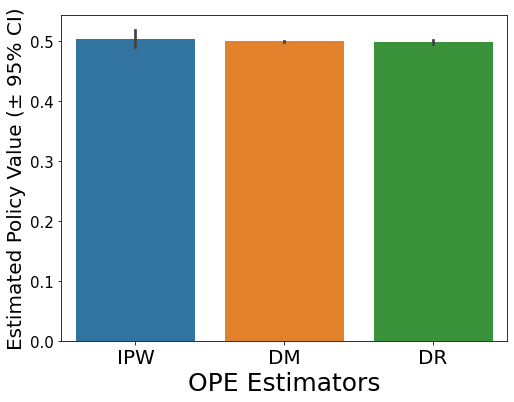

In [6]:
# estimated confidence intervals of policy value of BernoulliTS by OPE estimators
estimated_policy_value_a, estimated_interval_a = ope.summarize_off_policy_estimates(
    selected_actions=selected_actions_a
)
print(estimated_interval_a, '\n')
# visualize estimated policy values of BernoulliTS by the three OPE estimators
# and their 95% confidence intervals (estimated by nonparametric bootstrap method)
ope.visualize_off_policy_estimates(selected_actions=selected_actions_a)

mean  95.0% CI (lower)  95.0% CI (upper)
ipw  0.583103           0.57910           0.58719
dm   0.578520           0.57826           0.57888
dr   0.579857           0.57867           0.58105 



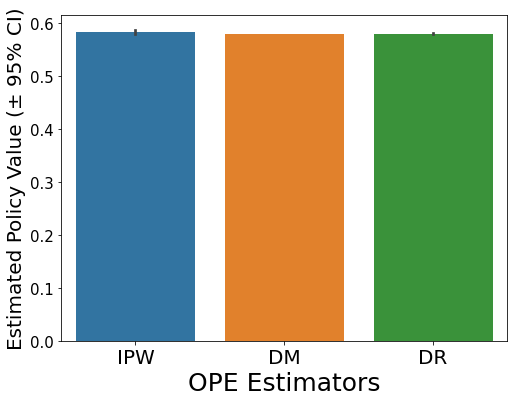

In [7]:
# estimated confidence intervals of policy value of Logistic Egreedy by OPE estimators
estimated_policy_value_b, estimated_interval_b = ope.summarize_off_policy_estimates(
    selected_actions=selected_actions_b
)
print(estimated_interval_b, '\n')
# visualize estimated policy values of BernoulliTS by the three OPE estimators
# and their 95% confidence intervals (estimated by nonparametric bootstrap method)
ope.visualize_off_policy_estimates(selected_actions=selected_actions_b)

Logistic Epsilon Greedy is estimated to outperform BernoulliTS by utilizing the context informaiton.

## (4) Evaluation of OPE estimators
Our final step is the evaluation of OPE estimators, which evaluates the accuracy of the OPE estimators in use.
With the synthetic dataset, we can know the ground-truth policy value of the counterfactual policies (Bernoulli TS and Logistc Egreedy). Therefore, we can compare the estimated policy values by OPE estimators with the ground-turths to evaluate estimators.

In [8]:
# we first estimate the ground-truth policy values of the counterfactual policies
# using the full expected reward contained in the bandit feedback dictionary
ground_truth_a = bandit_feedback['expected_reward'][np.arange(n_rounds), selected_actions_a.flatten()].mean()
ground_truth_b = bandit_feedback['expected_reward'][np.arange(n_rounds), selected_actions_b.flatten()].mean()

print(f'ground-truth policy value of Bernoulli TS: {ground_truth_a}')
print(f'ground-truth policy value of Logistic Egreedy: {ground_truth_b}')

ground-truth policy value of Bernoulli TS: 0.49991491038862523
ground-truth policy value of Logistic Egreedy: 0.5838843686551046


In [9]:
# evaluate the estimation performance of OPE estimators 
# by comparing the estimated policy value of BernolliTS and the ground-truth.
# `evaluate_performance_of_estimators` method returns a dictionary 
# containing the relative estimation error of given OPE estimators 
relative_estimation_errors_a = ope.evaluate_performance_of_estimators(
    selected_actions=selected_actions_a,
    ground_truth_policy_value=ground_truth_a
)

# Direct Method reveals the best estimation performance (lower is better)
# when evaluating the performance of BernoulliTS
relative_estimation_errors_a

{'ipw': 0.007992050989427764,
 'dm': 0.000598389277339997,
 'dr': 0.001102729837052683}

In [10]:
# evaluate the estimation performance of OPE estimators 
# by comparing the estimated policy value of LogisticTS and the ground-truth
# `evaluate_performance_of_estimators` method returns a dictionary 
# containing the relative estimation error of given OPE estimators 
relative_estimation_errors_b = ope.evaluate_performance_of_estimators(
    selected_actions=selected_actions_b,
    ground_truth_policy_value=ground_truth_b
)

# Inverse Probability Weighting reveals the best estimation performance (lower is better)
# when evaluating the performance of Logistic EGreedy
relative_estimation_errors_b

{'ipw': 0.0016164097143830326,
 'dm': 0.009219066212550824,
 'dr': 0.007043165074302069}

Please see [../synthetic/](https://github.com/st-tech/zr-obp/blob/master/examples/synthetic/) for a more sophisticated example of the evaluation of OPE.